In [4]:
import torch
from PIL import Image
import requests


In [5]:
from cog import BasePredictor, Input, Path
import cog

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
# from google.colab.patches import cv2_imshow
import re
from bs4 import BeautifulSoup #for reading xml file
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS  #for plotting wordcloud
from tqdm import tqdm
from PIL import Image    
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

In [7]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib #for saving model files as pkl files
import os
import seaborn as sns
import cv2
import imgaug.augmenters as iaa
sns.set(palette='muted',style='white')
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Input, Embedding, LSTM,Dot,Reshape,Concatenate,BatchNormalization, GlobalMaxPooling2D, Dropout, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu #bleu score
tf.compat.v1.enable_eager_execution()
import os
import math

In [8]:
import nltk.translate.bleu_score as bleu


In [9]:
import clip
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import skimage.io as io
import PIL.Image
from IPython.display import Image 


In [14]:
from torch.utils.data import Dataset

# class ImageCaptioningDataset(Dataset):
#     def __init__(self, dataset, processor):
#         self.dataset = dataset
#         self.processor = processor

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         item = self.dataset[idx]

#         encoding = self.processor(images=item["image"], text=item["caption"], padding="max_length", return_tensors="pt")

#         # remove batch dimension
#         encoding = {k:v.squeeze() for k,v in encoding.items()}

#         return encoding

In [15]:
N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]


D = torch.device
CPU = torch.device('cpu')


def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device


In [16]:
torch.backends.mps.is_available()

True

In [17]:
#@title Model

class MLP(nn.Module):

    def forward(self, x: T) -> T:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):

    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size: int, device: D) -> T:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: T, prefix: T, mask: Optional[T] = None, labels: Optional[T] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        #print(embedding_text.size()) #torch.Size([5, 67, 768])
        #print(prefix_projections.size()) #torch.Size([5, 1, 768])
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

In [18]:
class ClipROCODataset(Dataset):

    def __len__(self) -> int:
        return len(self.captions_tokens)

    def pad_tokens(self, item: int):
        tokens = self.captions_tokens[item]
        padding = self.max_seq_len - tokens.shape[0]
        if padding > 0:
            tokens = torch.cat((tokens, torch.zeros(padding, dtype=torch.int64) - 1))
            self.captions_tokens[item] = tokens
        elif padding < 0:
            tokens = tokens[:self.max_seq_len]
            self.captions_tokens[item] = tokens
        mask = tokens.ge(0)  # mask is zero where we out of sequence
        tokens[~mask] = 0
        mask = mask.float()
        mask = torch.cat((torch.ones(self.prefix_length), mask), dim=0)  # adding prefix mask
        return tokens, mask

    def __getitem__(self, item: int) -> Tuple[torch.Tensor, ...]:
        tokens, mask = self.pad_tokens(item)
        print(item)
        print(self.caption2embedding[item])
        print(self.prefixes)
        prefix = self.prefixes[self.caption2embedding[item]]
        if self.normalize_prefix:
            prefix = prefix.float()
            prefix = prefix / prefix.norm(2, -1)
        return tokens, mask, prefix

    def __init__(self, data_path: str,  prefix_length: int, gpt2_type: str = "gpt2",
                 normalize_prefix=False):
        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type)
        self.prefix_length = prefix_length
        self.normalize_prefix = normalize_prefix
        with open(data_path, 'rb') as f:
            all_data = pickle.load(f)
        print("Data size is %0d" % len(all_data["clip_embedding"]))
        #print(all_data.keys())
        sys.stdout.flush()
        self.prefixes = all_data["clip_embedding"]
        print(len(self.prefixes))
        captions_raw = all_data["captions"]
#         print(captions_raw[:5])
        self.image_ids = [caption["id"] for caption in captions_raw]
        self.captions = [caption['caption'] for caption in captions_raw]
        if os.path.isfile(f"{data_path[:-4]}_tokens.pkl"):
            with open(f"{data_path[:-4]}_tokens.pkl", 'rb') as f:
                self.captions_tokens, self.caption2embedding, self.max_seq_len = pickle.load(f)
        else:
            self.captions_tokens = []
            self.caption2embedding = []
            max_seq_len = 0
            for caption in captions_raw:
                self.captions_tokens.append(torch.tensor(self.tokenizer.encode(caption['caption']), dtype=torch.int64))
                self.caption2embedding.append(caption["clip_embedding"])
                max_seq_len = max(max_seq_len, self.captions_tokens[-1].shape[0])
            # self.max_seq_len = max_seq_len
            print(max_seq_len)
            with open(f"{data_path[:-4]}_tokens.pkl", 'wb') as f:
                pickle.dump([self.captions_tokens, self.caption2embedding, max_seq_len], f)
        all_len = torch.tensor([len(self.captions_tokens[i]) for i in range(len(self))]).float()
        print(len(self.caption2embedding))
        self.max_seq_len = min(int(all_len.mean() + all_len.std() * 10), int(all_len.max()))


In [19]:
#@title Caption prediction

def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts


def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

In [20]:
device

NameError: name 'device' is not defined

In [21]:
class Predictor(BasePredictor):
    def setup(self):
        """Load the model into memory to make running multiple predictions efficient"""
        self.device = torch.device("mps")
        self.clip_model, self.preprocess = clip.load(
            "ViT-B/32", device=self.device, jit=False
        )
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

        self.models = {}
        self.prefix_length = 10
        for key, weights_path in WEIGHTS_PATHS.items():
            model = ClipCaptionModel(self.prefix_length)
            model.load_state_dict(torch.load(weights_path, map_location=CPU))
            model = model.eval()
            model = model.to(self.device)
            self.models[key] = model

#     @cog.input("image", type=cog.Path, help="Input image")
#     @cog.input(
#         "model",
#         type=str,
#         options=WEIGHTS_PATHS.keys(),
#         default="coco",
#         help="Model to use",
#     )
#     @cog.input(
#         "use_beam_search",
#         type=bool,
#         default=False,
#         help="Whether to apply beam search to generate the output text",
#     )
    def predict(self, image, model, use_beam_search):
        """Run a single prediction on the model"""
        image = io.imread(image)
        model = self.models[model]
        pil_image = PIL.Image.fromarray(image)
        image = self.preprocess(pil_image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            prefix = self.clip_model.encode_image(image).to(
                self.device, dtype=torch.float32
            )
            prefix_embed = model.clip_project(prefix).reshape(1, self.prefix_length, -1)
        if use_beam_search:
            return generate_beam(model, self.tokenizer, embed=prefix_embed)[0]
        else:
            return generate2(model, self.tokenizer, embed=prefix_embed)


In [43]:
WEIGHTS_PATHS = {"latest":"/Users/simranmasand/Downloads/roco_prefix_latest.pt"}

In [46]:
predi = Predictor()

In [48]:
predi.setup()

In [49]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [50]:
### set up a prediction looop; i.e. generate all predictions for test set. then evaluate on images


In [54]:
%pwd

'/Users/simranmasand/Downloads'

In [55]:
test_data = load_from_disk('all_data/datasets/test')

In [56]:
test_dataset = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)

NameError: name 'processor' is not defined

In [51]:
for idx, (tokens, mask, prefix) in enumerate(test_dataloader):
    print(idx)
        

NameError: name 'test_dataloader' is not defined

In [10]:
is_gpu = False

In [22]:
device = "mps"
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [23]:
prefix_length = 10
model_path = "/Users/simranmasand/Downloads/cs263_final/checkpoints/roco_prefix_latest.pt"
model = ClipCaptionModel(prefix_length)

model.load_state_dict(torch.load(model_path, map_location=device)) 

model = model.eval() 
# device = CUDA(0) if is_gpu else "cpu"
model = model.to(device)

In [13]:
device

'mps'

In [14]:
from datasets import load_dataset
from datasets import load_from_disk
val_data = load_from_disk('all_data/datasets/val')
test_data = load_from_disk('all_data/datasets/test')

In [15]:
%pwd

'/Users/simranmasand/Downloads'

In [16]:
val_data

DatasetDict({
    train: Dataset({
        features: ['image', 'Unnamed: 0', 'id', 'caption'],
        num_rows: 8175
    })
})

In [17]:
val_data["train"][6]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=374x333>,
 'Unnamed: 0': 2600,
 'id': 'ROCO_26184',
 'caption': ' Arterial phase of the computed tomography scan of the abdomen shows a hypervascularized area (arrows) in the pancreatic body.\n'}

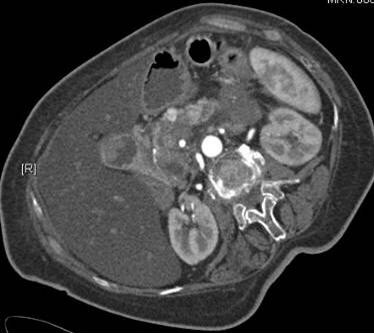

In [18]:
image = val_data["train"][6]["image"]
image

In [19]:
val_data["train"][6]["caption"]

' Arterial phase of the computed tomography scan of the abdomen shows a hypervascularized area (arrows) in the pancreatic body.\n'

In [20]:
#pil_image = PIL.Image.fromarray(image)
#pil_img = Image(filename=UPLOADED_FILE)
#display(pil_image)

image = preprocess(val_data["train"][6]["image"]).unsqueeze(0).to(device)


In [21]:
use_beam_search = False #@param {type:"boolean"}  

with torch.no_grad():
    # if type(model) is ClipCaptionE2E:
    #     prefix_embed = model.forward_image(image)
    # else:
    prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
if use_beam_search:
    generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
else:
    generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)


print('\n')
print(generated_text_prefix)

100%|██████████| 1/1 [00:02<00:00,  2.97s/it]



 Contrast-enhanced axial CT scan showing a large mass in the left colon.


In [46]:
OG = "Arterial phase of the computed tomography scan of the abdomen shows a hypervascularized area (arrows) in the pancreatic body."
PG2 = "Computed tomography scan of the abdomen showing a large mass in the left abdominal wall."

In [47]:
bleu.sentence_bleu(OG.split(),PG2.split(),weights=(1, 0, 0, 0))

0.0583448879361965

In [7]:
from torch.utils.data import DataLoader

val_dataset = ImageCaptioningDataset(val_data["train"], processor)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=1)

NameError: name 'processor' is not defined

In [48]:
model_path='all_data/checkpoint/roco_prefix_latest.pt'

In [49]:
CPU = torch.device('mps')
model.load_state_dict(torch.load(model_path, map_location=CPU)) 


RuntimeError: Error(s) in loading state_dict for ClipCaptionModel:
	Missing key(s) in state_dict: "gpt.transformer.wte.weight", "gpt.transformer.wpe.weight", "gpt.transformer.h.0.ln_1.weight", "gpt.transformer.h.0.ln_1.bias", "gpt.transformer.h.0.attn.bias", "gpt.transformer.h.0.attn.masked_bias", "gpt.transformer.h.0.attn.c_attn.weight", "gpt.transformer.h.0.attn.c_attn.bias", "gpt.transformer.h.0.attn.c_proj.weight", "gpt.transformer.h.0.attn.c_proj.bias", "gpt.transformer.h.0.ln_2.weight", "gpt.transformer.h.0.ln_2.bias", "gpt.transformer.h.0.mlp.c_fc.weight", "gpt.transformer.h.0.mlp.c_fc.bias", "gpt.transformer.h.0.mlp.c_proj.weight", "gpt.transformer.h.0.mlp.c_proj.bias", "gpt.transformer.h.1.ln_1.weight", "gpt.transformer.h.1.ln_1.bias", "gpt.transformer.h.1.attn.bias", "gpt.transformer.h.1.attn.masked_bias", "gpt.transformer.h.1.attn.c_attn.weight", "gpt.transformer.h.1.attn.c_attn.bias", "gpt.transformer.h.1.attn.c_proj.weight", "gpt.transformer.h.1.attn.c_proj.bias", "gpt.transformer.h.1.ln_2.weight", "gpt.transformer.h.1.ln_2.bias", "gpt.transformer.h.1.mlp.c_fc.weight", "gpt.transformer.h.1.mlp.c_fc.bias", "gpt.transformer.h.1.mlp.c_proj.weight", "gpt.transformer.h.1.mlp.c_proj.bias", "gpt.transformer.h.2.ln_1.weight", "gpt.transformer.h.2.ln_1.bias", "gpt.transformer.h.2.attn.bias", "gpt.transformer.h.2.attn.masked_bias", "gpt.transformer.h.2.attn.c_attn.weight", "gpt.transformer.h.2.attn.c_attn.bias", "gpt.transformer.h.2.attn.c_proj.weight", "gpt.transformer.h.2.attn.c_proj.bias", "gpt.transformer.h.2.ln_2.weight", "gpt.transformer.h.2.ln_2.bias", "gpt.transformer.h.2.mlp.c_fc.weight", "gpt.transformer.h.2.mlp.c_fc.bias", "gpt.transformer.h.2.mlp.c_proj.weight", "gpt.transformer.h.2.mlp.c_proj.bias", "gpt.transformer.h.3.ln_1.weight", "gpt.transformer.h.3.ln_1.bias", "gpt.transformer.h.3.attn.bias", "gpt.transformer.h.3.attn.masked_bias", "gpt.transformer.h.3.attn.c_attn.weight", "gpt.transformer.h.3.attn.c_attn.bias", "gpt.transformer.h.3.attn.c_proj.weight", "gpt.transformer.h.3.attn.c_proj.bias", "gpt.transformer.h.3.ln_2.weight", "gpt.transformer.h.3.ln_2.bias", "gpt.transformer.h.3.mlp.c_fc.weight", "gpt.transformer.h.3.mlp.c_fc.bias", "gpt.transformer.h.3.mlp.c_proj.weight", "gpt.transformer.h.3.mlp.c_proj.bias", "gpt.transformer.h.4.ln_1.weight", "gpt.transformer.h.4.ln_1.bias", "gpt.transformer.h.4.attn.bias", "gpt.transformer.h.4.attn.masked_bias", "gpt.transformer.h.4.attn.c_attn.weight", "gpt.transformer.h.4.attn.c_attn.bias", "gpt.transformer.h.4.attn.c_proj.weight", "gpt.transformer.h.4.attn.c_proj.bias", "gpt.transformer.h.4.ln_2.weight", "gpt.transformer.h.4.ln_2.bias", "gpt.transformer.h.4.mlp.c_fc.weight", "gpt.transformer.h.4.mlp.c_fc.bias", "gpt.transformer.h.4.mlp.c_proj.weight", "gpt.transformer.h.4.mlp.c_proj.bias", "gpt.transformer.h.5.ln_1.weight", "gpt.transformer.h.5.ln_1.bias", "gpt.transformer.h.5.attn.bias", "gpt.transformer.h.5.attn.masked_bias", "gpt.transformer.h.5.attn.c_attn.weight", "gpt.transformer.h.5.attn.c_attn.bias", "gpt.transformer.h.5.attn.c_proj.weight", "gpt.transformer.h.5.attn.c_proj.bias", "gpt.transformer.h.5.ln_2.weight", "gpt.transformer.h.5.ln_2.bias", "gpt.transformer.h.5.mlp.c_fc.weight", "gpt.transformer.h.5.mlp.c_fc.bias", "gpt.transformer.h.5.mlp.c_proj.weight", "gpt.transformer.h.5.mlp.c_proj.bias", "gpt.transformer.h.6.ln_1.weight", "gpt.transformer.h.6.ln_1.bias", "gpt.transformer.h.6.attn.bias", "gpt.transformer.h.6.attn.masked_bias", "gpt.transformer.h.6.attn.c_attn.weight", "gpt.transformer.h.6.attn.c_attn.bias", "gpt.transformer.h.6.attn.c_proj.weight", "gpt.transformer.h.6.attn.c_proj.bias", "gpt.transformer.h.6.ln_2.weight", "gpt.transformer.h.6.ln_2.bias", "gpt.transformer.h.6.mlp.c_fc.weight", "gpt.transformer.h.6.mlp.c_fc.bias", "gpt.transformer.h.6.mlp.c_proj.weight", "gpt.transformer.h.6.mlp.c_proj.bias", "gpt.transformer.h.7.ln_1.weight", "gpt.transformer.h.7.ln_1.bias", "gpt.transformer.h.7.attn.bias", "gpt.transformer.h.7.attn.masked_bias", "gpt.transformer.h.7.attn.c_attn.weight", "gpt.transformer.h.7.attn.c_attn.bias", "gpt.transformer.h.7.attn.c_proj.weight", "gpt.transformer.h.7.attn.c_proj.bias", "gpt.transformer.h.7.ln_2.weight", "gpt.transformer.h.7.ln_2.bias", "gpt.transformer.h.7.mlp.c_fc.weight", "gpt.transformer.h.7.mlp.c_fc.bias", "gpt.transformer.h.7.mlp.c_proj.weight", "gpt.transformer.h.7.mlp.c_proj.bias", "gpt.transformer.h.8.ln_1.weight", "gpt.transformer.h.8.ln_1.bias", "gpt.transformer.h.8.attn.bias", "gpt.transformer.h.8.attn.masked_bias", "gpt.transformer.h.8.attn.c_attn.weight", "gpt.transformer.h.8.attn.c_attn.bias", "gpt.transformer.h.8.attn.c_proj.weight", "gpt.transformer.h.8.attn.c_proj.bias", "gpt.transformer.h.8.ln_2.weight", "gpt.transformer.h.8.ln_2.bias", "gpt.transformer.h.8.mlp.c_fc.weight", "gpt.transformer.h.8.mlp.c_fc.bias", "gpt.transformer.h.8.mlp.c_proj.weight", "gpt.transformer.h.8.mlp.c_proj.bias", "gpt.transformer.h.9.ln_1.weight", "gpt.transformer.h.9.ln_1.bias", "gpt.transformer.h.9.attn.bias", "gpt.transformer.h.9.attn.masked_bias", "gpt.transformer.h.9.attn.c_attn.weight", "gpt.transformer.h.9.attn.c_attn.bias", "gpt.transformer.h.9.attn.c_proj.weight", "gpt.transformer.h.9.attn.c_proj.bias", "gpt.transformer.h.9.ln_2.weight", "gpt.transformer.h.9.ln_2.bias", "gpt.transformer.h.9.mlp.c_fc.weight", "gpt.transformer.h.9.mlp.c_fc.bias", "gpt.transformer.h.9.mlp.c_proj.weight", "gpt.transformer.h.9.mlp.c_proj.bias", "gpt.transformer.h.10.ln_1.weight", "gpt.transformer.h.10.ln_1.bias", "gpt.transformer.h.10.attn.bias", "gpt.transformer.h.10.attn.masked_bias", "gpt.transformer.h.10.attn.c_attn.weight", "gpt.transformer.h.10.attn.c_attn.bias", "gpt.transformer.h.10.attn.c_proj.weight", "gpt.transformer.h.10.attn.c_proj.bias", "gpt.transformer.h.10.ln_2.weight", "gpt.transformer.h.10.ln_2.bias", "gpt.transformer.h.10.mlp.c_fc.weight", "gpt.transformer.h.10.mlp.c_fc.bias", "gpt.transformer.h.10.mlp.c_proj.weight", "gpt.transformer.h.10.mlp.c_proj.bias", "gpt.transformer.h.11.ln_1.weight", "gpt.transformer.h.11.ln_1.bias", "gpt.transformer.h.11.attn.bias", "gpt.transformer.h.11.attn.masked_bias", "gpt.transformer.h.11.attn.c_attn.weight", "gpt.transformer.h.11.attn.c_attn.bias", "gpt.transformer.h.11.attn.c_proj.weight", "gpt.transformer.h.11.attn.c_proj.bias", "gpt.transformer.h.11.ln_2.weight", "gpt.transformer.h.11.ln_2.bias", "gpt.transformer.h.11.mlp.c_fc.weight", "gpt.transformer.h.11.mlp.c_fc.bias", "gpt.transformer.h.11.mlp.c_proj.weight", "gpt.transformer.h.11.mlp.c_proj.bias", "gpt.transformer.ln_f.weight", "gpt.transformer.ln_f.bias", "gpt.lm_head.weight", "clip_project.model.0.weight", "clip_project.model.0.bias", "clip_project.model.2.weight", "clip_project.model.2.bias". 
	Unexpected key(s) in state_dict: "vision_model.embeddings.class_embedding", "vision_model.embeddings.position_embedding", "vision_model.embeddings.patch_embedding.weight", "vision_model.embeddings.patch_embedding.bias", "vision_model.encoder.layers.0.self_attn.qkv.weight", "vision_model.encoder.layers.0.self_attn.qkv.bias", "vision_model.encoder.layers.0.self_attn.projection.weight", "vision_model.encoder.layers.0.self_attn.projection.bias", "vision_model.encoder.layers.0.layer_norm1.weight", "vision_model.encoder.layers.0.layer_norm1.bias", "vision_model.encoder.layers.0.mlp.fc1.weight", "vision_model.encoder.layers.0.mlp.fc1.bias", "vision_model.encoder.layers.0.mlp.fc2.weight", "vision_model.encoder.layers.0.mlp.fc2.bias", "vision_model.encoder.layers.0.layer_norm2.weight", "vision_model.encoder.layers.0.layer_norm2.bias", "vision_model.encoder.layers.1.self_attn.qkv.weight", "vision_model.encoder.layers.1.self_attn.qkv.bias", "vision_model.encoder.layers.1.self_attn.projection.weight", "vision_model.encoder.layers.1.self_attn.projection.bias", "vision_model.encoder.layers.1.layer_norm1.weight", "vision_model.encoder.layers.1.layer_norm1.bias", "vision_model.encoder.layers.1.mlp.fc1.weight", "vision_model.encoder.layers.1.mlp.fc1.bias", "vision_model.encoder.layers.1.mlp.fc2.weight", "vision_model.encoder.layers.1.mlp.fc2.bias", "vision_model.encoder.layers.1.layer_norm2.weight", "vision_model.encoder.layers.1.layer_norm2.bias", "vision_model.encoder.layers.2.self_attn.qkv.weight", "vision_model.encoder.layers.2.self_attn.qkv.bias", "vision_model.encoder.layers.2.self_attn.projection.weight", "vision_model.encoder.layers.2.self_attn.projection.bias", "vision_model.encoder.layers.2.layer_norm1.weight", "vision_model.encoder.layers.2.layer_norm1.bias", "vision_model.encoder.layers.2.mlp.fc1.weight", "vision_model.encoder.layers.2.mlp.fc1.bias", "vision_model.encoder.layers.2.mlp.fc2.weight", "vision_model.encoder.layers.2.mlp.fc2.bias", "vision_model.encoder.layers.2.layer_norm2.weight", "vision_model.encoder.layers.2.layer_norm2.bias", "vision_model.encoder.layers.3.self_attn.qkv.weight", "vision_model.encoder.layers.3.self_attn.qkv.bias", "vision_model.encoder.layers.3.self_attn.projection.weight", "vision_model.encoder.layers.3.self_attn.projection.bias", "vision_model.encoder.layers.3.layer_norm1.weight", "vision_model.encoder.layers.3.layer_norm1.bias", "vision_model.encoder.layers.3.mlp.fc1.weight", "vision_model.encoder.layers.3.mlp.fc1.bias", "vision_model.encoder.layers.3.mlp.fc2.weight", "vision_model.encoder.layers.3.mlp.fc2.bias", "vision_model.encoder.layers.3.layer_norm2.weight", "vision_model.encoder.layers.3.layer_norm2.bias", "vision_model.encoder.layers.4.self_attn.qkv.weight", "vision_model.encoder.layers.4.self_attn.qkv.bias", "vision_model.encoder.layers.4.self_attn.projection.weight", "vision_model.encoder.layers.4.self_attn.projection.bias", "vision_model.encoder.layers.4.layer_norm1.weight", "vision_model.encoder.layers.4.layer_norm1.bias", "vision_model.encoder.layers.4.mlp.fc1.weight", "vision_model.encoder.layers.4.mlp.fc1.bias", "vision_model.encoder.layers.4.mlp.fc2.weight", "vision_model.encoder.layers.4.mlp.fc2.bias", "vision_model.encoder.layers.4.layer_norm2.weight", "vision_model.encoder.layers.4.layer_norm2.bias", "vision_model.encoder.layers.5.self_attn.qkv.weight", "vision_model.encoder.layers.5.self_attn.qkv.bias", "vision_model.encoder.layers.5.self_attn.projection.weight", "vision_model.encoder.layers.5.self_attn.projection.bias", "vision_model.encoder.layers.5.layer_norm1.weight", "vision_model.encoder.layers.5.layer_norm1.bias", "vision_model.encoder.layers.5.mlp.fc1.weight", "vision_model.encoder.layers.5.mlp.fc1.bias", "vision_model.encoder.layers.5.mlp.fc2.weight", "vision_model.encoder.layers.5.mlp.fc2.bias", "vision_model.encoder.layers.5.layer_norm2.weight", "vision_model.encoder.layers.5.layer_norm2.bias", "vision_model.encoder.layers.6.self_attn.qkv.weight", "vision_model.encoder.layers.6.self_attn.qkv.bias", "vision_model.encoder.layers.6.self_attn.projection.weight", "vision_model.encoder.layers.6.self_attn.projection.bias", "vision_model.encoder.layers.6.layer_norm1.weight", "vision_model.encoder.layers.6.layer_norm1.bias", "vision_model.encoder.layers.6.mlp.fc1.weight", "vision_model.encoder.layers.6.mlp.fc1.bias", "vision_model.encoder.layers.6.mlp.fc2.weight", "vision_model.encoder.layers.6.mlp.fc2.bias", "vision_model.encoder.layers.6.layer_norm2.weight", "vision_model.encoder.layers.6.layer_norm2.bias", "vision_model.encoder.layers.7.self_attn.qkv.weight", "vision_model.encoder.layers.7.self_attn.qkv.bias", "vision_model.encoder.layers.7.self_attn.projection.weight", "vision_model.encoder.layers.7.self_attn.projection.bias", "vision_model.encoder.layers.7.layer_norm1.weight", "vision_model.encoder.layers.7.layer_norm1.bias", "vision_model.encoder.layers.7.mlp.fc1.weight", "vision_model.encoder.layers.7.mlp.fc1.bias", "vision_model.encoder.layers.7.mlp.fc2.weight", "vision_model.encoder.layers.7.mlp.fc2.bias", "vision_model.encoder.layers.7.layer_norm2.weight", "vision_model.encoder.layers.7.layer_norm2.bias", "vision_model.encoder.layers.8.self_attn.qkv.weight", "vision_model.encoder.layers.8.self_attn.qkv.bias", "vision_model.encoder.layers.8.self_attn.projection.weight", "vision_model.encoder.layers.8.self_attn.projection.bias", "vision_model.encoder.layers.8.layer_norm1.weight", "vision_model.encoder.layers.8.layer_norm1.bias", "vision_model.encoder.layers.8.mlp.fc1.weight", "vision_model.encoder.layers.8.mlp.fc1.bias", "vision_model.encoder.layers.8.mlp.fc2.weight", "vision_model.encoder.layers.8.mlp.fc2.bias", "vision_model.encoder.layers.8.layer_norm2.weight", "vision_model.encoder.layers.8.layer_norm2.bias", "vision_model.encoder.layers.9.self_attn.qkv.weight", "vision_model.encoder.layers.9.self_attn.qkv.bias", "vision_model.encoder.layers.9.self_attn.projection.weight", "vision_model.encoder.layers.9.self_attn.projection.bias", "vision_model.encoder.layers.9.layer_norm1.weight", "vision_model.encoder.layers.9.layer_norm1.bias", "vision_model.encoder.layers.9.mlp.fc1.weight", "vision_model.encoder.layers.9.mlp.fc1.bias", "vision_model.encoder.layers.9.mlp.fc2.weight", "vision_model.encoder.layers.9.mlp.fc2.bias", "vision_model.encoder.layers.9.layer_norm2.weight", "vision_model.encoder.layers.9.layer_norm2.bias", "vision_model.encoder.layers.10.self_attn.qkv.weight", "vision_model.encoder.layers.10.self_attn.qkv.bias", "vision_model.encoder.layers.10.self_attn.projection.weight", "vision_model.encoder.layers.10.self_attn.projection.bias", "vision_model.encoder.layers.10.layer_norm1.weight", "vision_model.encoder.layers.10.layer_norm1.bias", "vision_model.encoder.layers.10.mlp.fc1.weight", "vision_model.encoder.layers.10.mlp.fc1.bias", "vision_model.encoder.layers.10.mlp.fc2.weight", "vision_model.encoder.layers.10.mlp.fc2.bias", "vision_model.encoder.layers.10.layer_norm2.weight", "vision_model.encoder.layers.10.layer_norm2.bias", "vision_model.encoder.layers.11.self_attn.qkv.weight", "vision_model.encoder.layers.11.self_attn.qkv.bias", "vision_model.encoder.layers.11.self_attn.projection.weight", "vision_model.encoder.layers.11.self_attn.projection.bias", "vision_model.encoder.layers.11.layer_norm1.weight", "vision_model.encoder.layers.11.layer_norm1.bias", "vision_model.encoder.layers.11.mlp.fc1.weight", "vision_model.encoder.layers.11.mlp.fc1.bias", "vision_model.encoder.layers.11.mlp.fc2.weight", "vision_model.encoder.layers.11.mlp.fc2.bias", "vision_model.encoder.layers.11.layer_norm2.weight", "vision_model.encoder.layers.11.layer_norm2.bias", "vision_model.post_layernorm.weight", "vision_model.post_layernorm.bias", "text_decoder.bert.embeddings.position_ids", "text_decoder.bert.embeddings.word_embeddings.weight", "text_decoder.bert.embeddings.position_embeddings.weight", "text_decoder.bert.embeddings.LayerNorm.weight", "text_decoder.bert.embeddings.LayerNorm.bias", "text_decoder.bert.encoder.layer.0.attention.self.query.weight", "text_decoder.bert.encoder.layer.0.attention.self.query.bias", "text_decoder.bert.encoder.layer.0.attention.self.key.weight", "text_decoder.bert.encoder.layer.0.attention.self.key.bias", "text_decoder.bert.encoder.layer.0.attention.self.value.weight", "text_decoder.bert.encoder.layer.0.attention.self.value.bias", "text_decoder.bert.encoder.layer.0.attention.output.dense.weight", "text_decoder.bert.encoder.layer.0.attention.output.dense.bias", "text_decoder.bert.encoder.layer.0.attention.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.0.attention.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.0.crossattention.self.query.weight", "text_decoder.bert.encoder.layer.0.crossattention.self.query.bias", "text_decoder.bert.encoder.layer.0.crossattention.self.key.weight", "text_decoder.bert.encoder.layer.0.crossattention.self.key.bias", "text_decoder.bert.encoder.layer.0.crossattention.self.value.weight", "text_decoder.bert.encoder.layer.0.crossattention.self.value.bias", "text_decoder.bert.encoder.layer.0.crossattention.output.dense.weight", "text_decoder.bert.encoder.layer.0.crossattention.output.dense.bias", "text_decoder.bert.encoder.layer.0.crossattention.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.0.crossattention.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.0.intermediate.dense.weight", "text_decoder.bert.encoder.layer.0.intermediate.dense.bias", "text_decoder.bert.encoder.layer.0.output.dense.weight", "text_decoder.bert.encoder.layer.0.output.dense.bias", "text_decoder.bert.encoder.layer.0.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.0.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.1.attention.self.query.weight", "text_decoder.bert.encoder.layer.1.attention.self.query.bias", "text_decoder.bert.encoder.layer.1.attention.self.key.weight", "text_decoder.bert.encoder.layer.1.attention.self.key.bias", "text_decoder.bert.encoder.layer.1.attention.self.value.weight", "text_decoder.bert.encoder.layer.1.attention.self.value.bias", "text_decoder.bert.encoder.layer.1.attention.output.dense.weight", "text_decoder.bert.encoder.layer.1.attention.output.dense.bias", "text_decoder.bert.encoder.layer.1.attention.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.1.attention.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.1.crossattention.self.query.weight", "text_decoder.bert.encoder.layer.1.crossattention.self.query.bias", "text_decoder.bert.encoder.layer.1.crossattention.self.key.weight", "text_decoder.bert.encoder.layer.1.crossattention.self.key.bias", "text_decoder.bert.encoder.layer.1.crossattention.self.value.weight", "text_decoder.bert.encoder.layer.1.crossattention.self.value.bias", "text_decoder.bert.encoder.layer.1.crossattention.output.dense.weight", "text_decoder.bert.encoder.layer.1.crossattention.output.dense.bias", "text_decoder.bert.encoder.layer.1.crossattention.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.1.crossattention.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.1.intermediate.dense.weight", "text_decoder.bert.encoder.layer.1.intermediate.dense.bias", "text_decoder.bert.encoder.layer.1.output.dense.weight", "text_decoder.bert.encoder.layer.1.output.dense.bias", "text_decoder.bert.encoder.layer.1.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.1.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.2.attention.self.query.weight", "text_decoder.bert.encoder.layer.2.attention.self.query.bias", "text_decoder.bert.encoder.layer.2.attention.self.key.weight", "text_decoder.bert.encoder.layer.2.attention.self.key.bias", "text_decoder.bert.encoder.layer.2.attention.self.value.weight", "text_decoder.bert.encoder.layer.2.attention.self.value.bias", "text_decoder.bert.encoder.layer.2.attention.output.dense.weight", "text_decoder.bert.encoder.layer.2.attention.output.dense.bias", "text_decoder.bert.encoder.layer.2.attention.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.2.attention.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.2.crossattention.self.query.weight", "text_decoder.bert.encoder.layer.2.crossattention.self.query.bias", "text_decoder.bert.encoder.layer.2.crossattention.self.key.weight", "text_decoder.bert.encoder.layer.2.crossattention.self.key.bias", "text_decoder.bert.encoder.layer.2.crossattention.self.value.weight", "text_decoder.bert.encoder.layer.2.crossattention.self.value.bias", "text_decoder.bert.encoder.layer.2.crossattention.output.dense.weight", "text_decoder.bert.encoder.layer.2.crossattention.output.dense.bias", "text_decoder.bert.encoder.layer.2.crossattention.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.2.crossattention.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.2.intermediate.dense.weight", "text_decoder.bert.encoder.layer.2.intermediate.dense.bias", "text_decoder.bert.encoder.layer.2.output.dense.weight", "text_decoder.bert.encoder.layer.2.output.dense.bias", "text_decoder.bert.encoder.layer.2.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.2.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.3.attention.self.query.weight", "text_decoder.bert.encoder.layer.3.attention.self.query.bias", "text_decoder.bert.encoder.layer.3.attention.self.key.weight", "text_decoder.bert.encoder.layer.3.attention.self.key.bias", "text_decoder.bert.encoder.layer.3.attention.self.value.weight", "text_decoder.bert.encoder.layer.3.attention.self.value.bias", "text_decoder.bert.encoder.layer.3.attention.output.dense.weight", "text_decoder.bert.encoder.layer.3.attention.output.dense.bias", "text_decoder.bert.encoder.layer.3.attention.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.3.attention.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.3.crossattention.self.query.weight", "text_decoder.bert.encoder.layer.3.crossattention.self.query.bias", "text_decoder.bert.encoder.layer.3.crossattention.self.key.weight", "text_decoder.bert.encoder.layer.3.crossattention.self.key.bias", "text_decoder.bert.encoder.layer.3.crossattention.self.value.weight", "text_decoder.bert.encoder.layer.3.crossattention.self.value.bias", "text_decoder.bert.encoder.layer.3.crossattention.output.dense.weight", "text_decoder.bert.encoder.layer.3.crossattention.output.dense.bias", "text_decoder.bert.encoder.layer.3.crossattention.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.3.crossattention.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.3.intermediate.dense.weight", "text_decoder.bert.encoder.layer.3.intermediate.dense.bias", "text_decoder.bert.encoder.layer.3.output.dense.weight", "text_decoder.bert.encoder.layer.3.output.dense.bias", "text_decoder.bert.encoder.layer.3.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.3.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.4.attention.self.query.weight", "text_decoder.bert.encoder.layer.4.attention.self.query.bias", "text_decoder.bert.encoder.layer.4.attention.self.key.weight", "text_decoder.bert.encoder.layer.4.attention.self.key.bias", "text_decoder.bert.encoder.layer.4.attention.self.value.weight", "text_decoder.bert.encoder.layer.4.attention.self.value.bias", "text_decoder.bert.encoder.layer.4.attention.output.dense.weight", "text_decoder.bert.encoder.layer.4.attention.output.dense.bias", "text_decoder.bert.encoder.layer.4.attention.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.4.attention.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.4.crossattention.self.query.weight", "text_decoder.bert.encoder.layer.4.crossattention.self.query.bias", "text_decoder.bert.encoder.layer.4.crossattention.self.key.weight", "text_decoder.bert.encoder.layer.4.crossattention.self.key.bias", "text_decoder.bert.encoder.layer.4.crossattention.self.value.weight", "text_decoder.bert.encoder.layer.4.crossattention.self.value.bias", "text_decoder.bert.encoder.layer.4.crossattention.output.dense.weight", "text_decoder.bert.encoder.layer.4.crossattention.output.dense.bias", "text_decoder.bert.encoder.layer.4.crossattention.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.4.crossattention.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.4.intermediate.dense.weight", "text_decoder.bert.encoder.layer.4.intermediate.dense.bias", "text_decoder.bert.encoder.layer.4.output.dense.weight", "text_decoder.bert.encoder.layer.4.output.dense.bias", "text_decoder.bert.encoder.layer.4.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.4.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.5.attention.self.query.weight", "text_decoder.bert.encoder.layer.5.attention.self.query.bias", "text_decoder.bert.encoder.layer.5.attention.self.key.weight", "text_decoder.bert.encoder.layer.5.attention.self.key.bias", "text_decoder.bert.encoder.layer.5.attention.self.value.weight", "text_decoder.bert.encoder.layer.5.attention.self.value.bias", "text_decoder.bert.encoder.layer.5.attention.output.dense.weight", "text_decoder.bert.encoder.layer.5.attention.output.dense.bias", "text_decoder.bert.encoder.layer.5.attention.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.5.attention.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.5.crossattention.self.query.weight", "text_decoder.bert.encoder.layer.5.crossattention.self.query.bias", "text_decoder.bert.encoder.layer.5.crossattention.self.key.weight", "text_decoder.bert.encoder.layer.5.crossattention.self.key.bias", "text_decoder.bert.encoder.layer.5.crossattention.self.value.weight", "text_decoder.bert.encoder.layer.5.crossattention.self.value.bias", "text_decoder.bert.encoder.layer.5.crossattention.output.dense.weight", "text_decoder.bert.encoder.layer.5.crossattention.output.dense.bias", "text_decoder.bert.encoder.layer.5.crossattention.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.5.crossattention.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.5.intermediate.dense.weight", "text_decoder.bert.encoder.layer.5.intermediate.dense.bias", "text_decoder.bert.encoder.layer.5.output.dense.weight", "text_decoder.bert.encoder.layer.5.output.dense.bias", "text_decoder.bert.encoder.layer.5.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.5.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.6.attention.self.query.weight", "text_decoder.bert.encoder.layer.6.attention.self.query.bias", "text_decoder.bert.encoder.layer.6.attention.self.key.weight", "text_decoder.bert.encoder.layer.6.attention.self.key.bias", "text_decoder.bert.encoder.layer.6.attention.self.value.weight", "text_decoder.bert.encoder.layer.6.attention.self.value.bias", "text_decoder.bert.encoder.layer.6.attention.output.dense.weight", "text_decoder.bert.encoder.layer.6.attention.output.dense.bias", "text_decoder.bert.encoder.layer.6.attention.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.6.attention.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.6.crossattention.self.query.weight", "text_decoder.bert.encoder.layer.6.crossattention.self.query.bias", "text_decoder.bert.encoder.layer.6.crossattention.self.key.weight", "text_decoder.bert.encoder.layer.6.crossattention.self.key.bias", "text_decoder.bert.encoder.layer.6.crossattention.self.value.weight", "text_decoder.bert.encoder.layer.6.crossattention.self.value.bias", "text_decoder.bert.encoder.layer.6.crossattention.output.dense.weight", "text_decoder.bert.encoder.layer.6.crossattention.output.dense.bias", "text_decoder.bert.encoder.layer.6.crossattention.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.6.crossattention.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.6.intermediate.dense.weight", "text_decoder.bert.encoder.layer.6.intermediate.dense.bias", "text_decoder.bert.encoder.layer.6.output.dense.weight", "text_decoder.bert.encoder.layer.6.output.dense.bias", "text_decoder.bert.encoder.layer.6.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.6.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.7.attention.self.query.weight", "text_decoder.bert.encoder.layer.7.attention.self.query.bias", "text_decoder.bert.encoder.layer.7.attention.self.key.weight", "text_decoder.bert.encoder.layer.7.attention.self.key.bias", "text_decoder.bert.encoder.layer.7.attention.self.value.weight", "text_decoder.bert.encoder.layer.7.attention.self.value.bias", "text_decoder.bert.encoder.layer.7.attention.output.dense.weight", "text_decoder.bert.encoder.layer.7.attention.output.dense.bias", "text_decoder.bert.encoder.layer.7.attention.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.7.attention.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.7.crossattention.self.query.weight", "text_decoder.bert.encoder.layer.7.crossattention.self.query.bias", "text_decoder.bert.encoder.layer.7.crossattention.self.key.weight", "text_decoder.bert.encoder.layer.7.crossattention.self.key.bias", "text_decoder.bert.encoder.layer.7.crossattention.self.value.weight", "text_decoder.bert.encoder.layer.7.crossattention.self.value.bias", "text_decoder.bert.encoder.layer.7.crossattention.output.dense.weight", "text_decoder.bert.encoder.layer.7.crossattention.output.dense.bias", "text_decoder.bert.encoder.layer.7.crossattention.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.7.crossattention.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.7.intermediate.dense.weight", "text_decoder.bert.encoder.layer.7.intermediate.dense.bias", "text_decoder.bert.encoder.layer.7.output.dense.weight", "text_decoder.bert.encoder.layer.7.output.dense.bias", "text_decoder.bert.encoder.layer.7.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.7.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.8.attention.self.query.weight", "text_decoder.bert.encoder.layer.8.attention.self.query.bias", "text_decoder.bert.encoder.layer.8.attention.self.key.weight", "text_decoder.bert.encoder.layer.8.attention.self.key.bias", "text_decoder.bert.encoder.layer.8.attention.self.value.weight", "text_decoder.bert.encoder.layer.8.attention.self.value.bias", "text_decoder.bert.encoder.layer.8.attention.output.dense.weight", "text_decoder.bert.encoder.layer.8.attention.output.dense.bias", "text_decoder.bert.encoder.layer.8.attention.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.8.attention.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.8.crossattention.self.query.weight", "text_decoder.bert.encoder.layer.8.crossattention.self.query.bias", "text_decoder.bert.encoder.layer.8.crossattention.self.key.weight", "text_decoder.bert.encoder.layer.8.crossattention.self.key.bias", "text_decoder.bert.encoder.layer.8.crossattention.self.value.weight", "text_decoder.bert.encoder.layer.8.crossattention.self.value.bias", "text_decoder.bert.encoder.layer.8.crossattention.output.dense.weight", "text_decoder.bert.encoder.layer.8.crossattention.output.dense.bias", "text_decoder.bert.encoder.layer.8.crossattention.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.8.crossattention.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.8.intermediate.dense.weight", "text_decoder.bert.encoder.layer.8.intermediate.dense.bias", "text_decoder.bert.encoder.layer.8.output.dense.weight", "text_decoder.bert.encoder.layer.8.output.dense.bias", "text_decoder.bert.encoder.layer.8.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.8.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.9.attention.self.query.weight", "text_decoder.bert.encoder.layer.9.attention.self.query.bias", "text_decoder.bert.encoder.layer.9.attention.self.key.weight", "text_decoder.bert.encoder.layer.9.attention.self.key.bias", "text_decoder.bert.encoder.layer.9.attention.self.value.weight", "text_decoder.bert.encoder.layer.9.attention.self.value.bias", "text_decoder.bert.encoder.layer.9.attention.output.dense.weight", "text_decoder.bert.encoder.layer.9.attention.output.dense.bias", "text_decoder.bert.encoder.layer.9.attention.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.9.attention.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.9.crossattention.self.query.weight", "text_decoder.bert.encoder.layer.9.crossattention.self.query.bias", "text_decoder.bert.encoder.layer.9.crossattention.self.key.weight", "text_decoder.bert.encoder.layer.9.crossattention.self.key.bias", "text_decoder.bert.encoder.layer.9.crossattention.self.value.weight", "text_decoder.bert.encoder.layer.9.crossattention.self.value.bias", "text_decoder.bert.encoder.layer.9.crossattention.output.dense.weight", "text_decoder.bert.encoder.layer.9.crossattention.output.dense.bias", "text_decoder.bert.encoder.layer.9.crossattention.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.9.crossattention.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.9.intermediate.dense.weight", "text_decoder.bert.encoder.layer.9.intermediate.dense.bias", "text_decoder.bert.encoder.layer.9.output.dense.weight", "text_decoder.bert.encoder.layer.9.output.dense.bias", "text_decoder.bert.encoder.layer.9.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.9.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.10.attention.self.query.weight", "text_decoder.bert.encoder.layer.10.attention.self.query.bias", "text_decoder.bert.encoder.layer.10.attention.self.key.weight", "text_decoder.bert.encoder.layer.10.attention.self.key.bias", "text_decoder.bert.encoder.layer.10.attention.self.value.weight", "text_decoder.bert.encoder.layer.10.attention.self.value.bias", "text_decoder.bert.encoder.layer.10.attention.output.dense.weight", "text_decoder.bert.encoder.layer.10.attention.output.dense.bias", "text_decoder.bert.encoder.layer.10.attention.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.10.attention.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.10.crossattention.self.query.weight", "text_decoder.bert.encoder.layer.10.crossattention.self.query.bias", "text_decoder.bert.encoder.layer.10.crossattention.self.key.weight", "text_decoder.bert.encoder.layer.10.crossattention.self.key.bias", "text_decoder.bert.encoder.layer.10.crossattention.self.value.weight", "text_decoder.bert.encoder.layer.10.crossattention.self.value.bias", "text_decoder.bert.encoder.layer.10.crossattention.output.dense.weight", "text_decoder.bert.encoder.layer.10.crossattention.output.dense.bias", "text_decoder.bert.encoder.layer.10.crossattention.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.10.crossattention.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.10.intermediate.dense.weight", "text_decoder.bert.encoder.layer.10.intermediate.dense.bias", "text_decoder.bert.encoder.layer.10.output.dense.weight", "text_decoder.bert.encoder.layer.10.output.dense.bias", "text_decoder.bert.encoder.layer.10.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.10.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.11.attention.self.query.weight", "text_decoder.bert.encoder.layer.11.attention.self.query.bias", "text_decoder.bert.encoder.layer.11.attention.self.key.weight", "text_decoder.bert.encoder.layer.11.attention.self.key.bias", "text_decoder.bert.encoder.layer.11.attention.self.value.weight", "text_decoder.bert.encoder.layer.11.attention.self.value.bias", "text_decoder.bert.encoder.layer.11.attention.output.dense.weight", "text_decoder.bert.encoder.layer.11.attention.output.dense.bias", "text_decoder.bert.encoder.layer.11.attention.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.11.attention.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.11.crossattention.self.query.weight", "text_decoder.bert.encoder.layer.11.crossattention.self.query.bias", "text_decoder.bert.encoder.layer.11.crossattention.self.key.weight", "text_decoder.bert.encoder.layer.11.crossattention.self.key.bias", "text_decoder.bert.encoder.layer.11.crossattention.self.value.weight", "text_decoder.bert.encoder.layer.11.crossattention.self.value.bias", "text_decoder.bert.encoder.layer.11.crossattention.output.dense.weight", "text_decoder.bert.encoder.layer.11.crossattention.output.dense.bias", "text_decoder.bert.encoder.layer.11.crossattention.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.11.crossattention.output.LayerNorm.bias", "text_decoder.bert.encoder.layer.11.intermediate.dense.weight", "text_decoder.bert.encoder.layer.11.intermediate.dense.bias", "text_decoder.bert.encoder.layer.11.output.dense.weight", "text_decoder.bert.encoder.layer.11.output.dense.bias", "text_decoder.bert.encoder.layer.11.output.LayerNorm.weight", "text_decoder.bert.encoder.layer.11.output.LayerNorm.bias", "text_decoder.cls.predictions.bias", "text_decoder.cls.predictions.transform.dense.weight", "text_decoder.cls.predictions.transform.dense.bias", "text_decoder.cls.predictions.transform.LayerNorm.weight", "text_decoder.cls.predictions.transform.LayerNorm.bias", "text_decoder.cls.predictions.decoder.weight", "text_decoder.cls.predictions.decoder.bias". 

In [61]:
val_data

DatasetDict({
    train: Dataset({
        features: ['image', 'Unnamed: 0', 'id', 'caption'],
        num_rows: 8175
    })
})

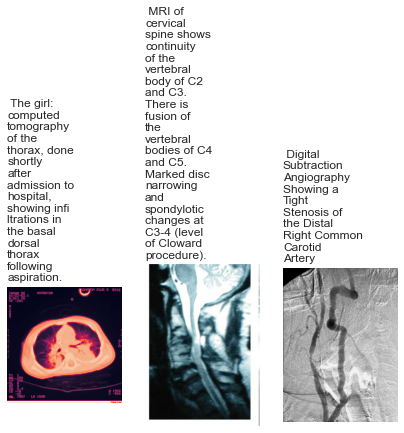

In [75]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(7, 7))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption,loc='left')
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(val_data["train"][i]["image"]) for i in range(3)]
sample_captions = [val_data["train"][i]["caption"] for i in range(3)]
plot_images(sample_images_to_visualize, sample_captions)

In [22]:
# def transforms(example_batch):
#     images = [x for x in example_batch["image"]]
#     captions = [x for x in example_batch["caption"]]
#     inputs = processor(images=images, text=captions, padding="max_length")
#     inputs.update({"labels": inputs["input_ids"]})
#     return inputs


# val_data["train"].set_transform(transforms)

In [69]:
val_data["train"][6]["caption"].replace("\n","").strip()

'Arterial phase of the computed tomography scan of the abdomen shows a hypervascularized area (arrows) in the pancreatic body.'

In [26]:
from evaluate import load
import torch

wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

In [50]:
val_data["train"][6]

{'pixel_values': array([[[-1.7776641 , -1.7776641 , -1.7776641 , ..., -1.1061366 ,
          -1.7922626 , -1.6754751 ],
         [-1.7776641 , -1.7776641 , -1.7776641 , ..., -1.0331444 ,
          -1.7922626 , -1.7484672 ],
         [-1.7776641 , -1.7776641 , -1.7776641 , ...,  0.16392669,
           0.32450938,  0.25151724],
         ...,
         [-1.7776641 , -1.4856956 , -1.7630657 , ..., -1.7776641 ,
          -1.7776641 , -1.7776641 ],
         [-1.7630657 , -1.6462783 , -1.6900735 , ..., -1.7630657 ,
          -1.7630657 , -1.7630657 ],
         [-1.7776641 , -1.7338688 , -1.5878845 , ..., -1.7922626 ,
          -1.7922626 , -1.7922626 ]],
 
        [[-1.7370893 , -1.7370893 , -1.7370893 , ..., -1.0467321 ,
          -1.7520971 , -1.6320349 ],
         [-1.7370893 , -1.7370893 , -1.7370893 , ..., -0.9716932 ,
          -1.7520971 , -1.7070738 ],
         [-1.7370893 , -1.7370893 , -1.7370893 , ...,  0.25894392,
           0.42402935,  0.34899053],
         ...,
         [-1.7370

In [48]:
image = val_data["train"][6]["pixel_values"]
inputs = processor(images=image.astype(np.uint8), return_tensors="pt")#.to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

ct scan of the abdomen showing a large heterogeneous mass in the right upper lobe.


In [64]:
import nltk.translate.bleu_score as bleu


In [70]:
bleu.sentence_bleu(val_data["train"][6]["caption"].replace("\n","").strip().split(),generated_caption.split(),weights=(1, 0, 0, 0))

0.0583448879361965

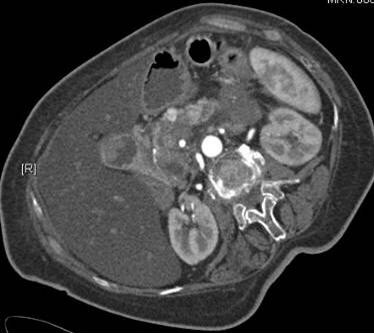

In [85]:
val_data["train"][6]["image"]

In [77]:
OG="the tracheostomy tube is in stable position. right subclavian catheter tip is in the lower svc. the left upper etremity picc tip is in the mid svc. surgical overlie the soft tissues of the neck. the lungs are clear. heart size is normal. no pneumothora."
PG="the lungs are clear. there is no pleural effusion or pneumothora. the heart and mediastinum are normal. the skeletal structures are normal."

In [79]:
Adj = " the lungs are clear. heart size is normal. no pneumothora."

In [80]:
bleu.sentence_bleu(OG.split(),Adj.split(),weights=(1, 0, 0, 0))

0

In [ ]:
b1 = 0
b2 = 0
b3 = 0
b4 = 0


for i in range(X_test.shape[0]):
  im_o = np.vstack(X_test[:,4][i]).astype(np.float)
  pred = beam(im_o)
  org= X_test[:,5][i]

  

  
  b1 =  b1 + bleu.sentence_bleu([org.split()], pred.split() ,weights=(1, 0, 0, 0))
  b2 =  b2 + bleu.sentence_bleu([org.split()], pred.split(),weights=(0.5, 0.5, 0, 0))
  b3 =  b3 + bleu.sentence_bleu([org.split()], pred.split() ,weights=(0.33, 0.33, 0.33, 0))
  b4 =  b4 + bleu.sentence_bleu([org.split()], pred.split() ,weights=(0.25, 0.25, 0.25, 0.25))



print("Bleu1 score is : ",b1/X_test.shape[0])
print("Bleu2 score is : ",b2/X_test.shape[0])
print("Bleu3 score is : ",b3/X_test.shape[0])
print("Bleu4 score is : ",b4/X_test.shape[0])